In [87]:
# notebooks use their location as their working directory, so
# if we are in a subfolder, move to the main folder.  
# This however can safely be run multiple times
#setwd("M:/lecospec/lecospec")
if(!dir.exists("Functions/")){
    setwd("../")
    if(!dir.exists("Functions")){
        setwd("M:/lecospec/lecospec/")
    }
}
source("Functions/lecospectR.R", echo = FALSE)
library(class)
library(caret)
library(vegan)

## Load the Data

In [88]:
# spectral library
base_path <- "./Output/C_001_SC3_Cleaned_SpectralLib.csv"
veg_index_path <- "./Data/D_002_SpecLib_Derivs.csv"
speclib <- read.csv(base_path)
veg_indices <- read.csv(veg_index_path)

In [89]:
# Targets 
targets <- veg_indices[!is.na(veg_indices$Functional_group1),"Functional_group1"] %>% as.factor()
# weights
weights_by_pft <- targets_to_weights(targets)

In [90]:
# image-based validation
uav_speclib_df <- read.csv(
    "Data/Ground_Validation/PFT_image_spectra/PFT_Image_SpectralLib_Clean_unsmoothed.csv", 
    header = TRUE)
image_validation <- uav_speclib_df[,16:(ncol(uav_speclib_df) - 1)]
validation_labels <- uav_speclib_df$FncGrp1 %>% as.factor()
#levels(validation_labels) <- c(levels(validation_labels), "Forb") 



## Base transformation
This removes infinity, outliers and NAs from the data.  

[1] "Imputing..."
[1] "Imputing..."


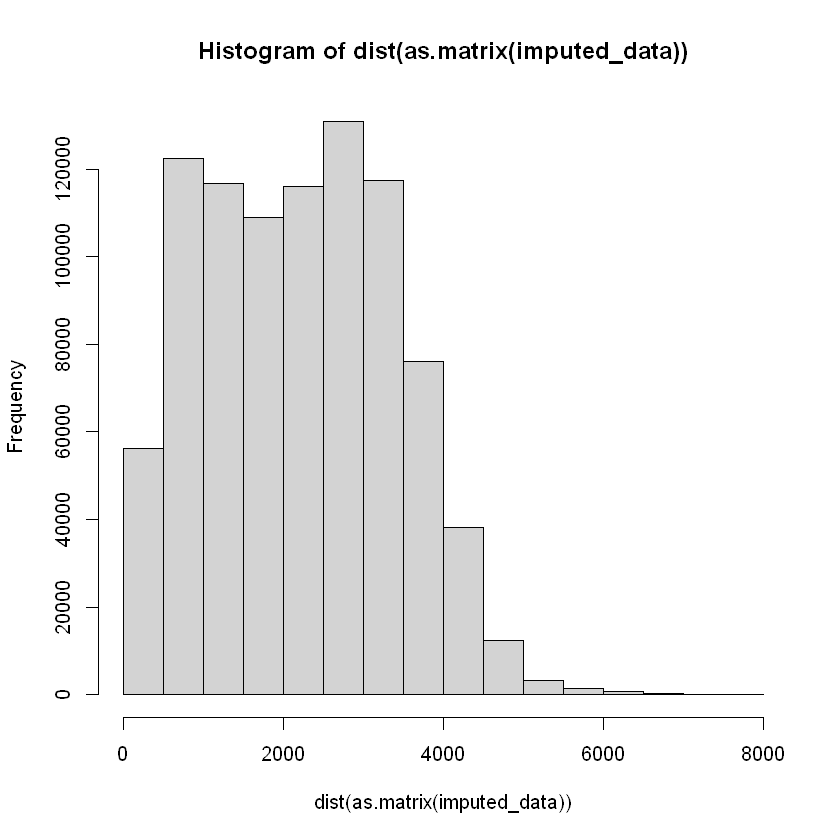

In [91]:
numeric_data <- veg_indices[!is.na(veg_indices$Functional_group1),35:(ncol(veg_indices)-1)]
numeric_data <- inf_to_na(numeric_data)
imputed_data_1 <- impute_spectra(numeric_data)
imputed_data_no_outliers <- outliers_to_na(imputed_data_1)
imputed_data <- impute_spectra(imputed_data_no_outliers)
outlier_indices <- detect_outliers_columnwise(imputed_data[,1:95])
filtered_data <- imputed_data[!outlier_indices,]
hist(dist(as.matrix(imputed_data)))
min_max_scaled_data <- columnwise_min_max_scale(imputed_data)

In [92]:
print(colnames(imputed_data))

  [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
  [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
 [11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
 [16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
 [21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
 [26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
 [31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
 [36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
 [41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
 [46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
 [51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
 [56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
 [61] "PARS"         "PRI"  

## Transform the Image-based Data

In [93]:
veg_index_names <- read.csv("assets/vegIndicesUsed.csv")$x
validation_indices <- get_vegetation_indices(image_validation, NULL)
# drop NAs

validation_indices <- inf_to_na(validation_indices)
validation_indices <- impute_spectra(validation_indices)
validation_indices <- outliers_to_na(validation_indices)
validation_indices <- impute_spectra(validation_indices)


min_max_scaled_validation <- columnwise_min_max_scale(validation_indices)

#hist(as.matrix(min_max_scaled_validation))

[1] "Imputing..."
[1] "Imputing..."


In [94]:
validation_bands <- resample_df(image_validation,normalize = FALSE)

Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



In [95]:
print(colnames(validation_bands))

  [1] "X397.593"     "X399.444"     "X401.296"     "X403.148"     "X405"        
  [6] "X406.851"     "X408.703"     "X410.555"     "X412.407"     "X414.258"    
 [11] "X416.11"      "X417.962"     "X419.814"     "X421.666"     "X423.517"    
 [16] "X425.369"     "X427.221"     "X429.073"     "X430.924"     "X432.776"    
 [21] "X434.628"     "X436.48"      "X438.332"     "X440.183"     "X442.035"    
 [26] "X443.887"     "X445.739"     "X447.59"      "X449.442"     "X451.294"    
 [31] "X453.146"     "X454.998"     "X456.849"     "X458.701"     "X460.553"    
 [36] "X462.405"     "X464.256"     "X466.108"     "X467.96"      "X469.812"    
 [41] "X471.664"     "X473.515"     "X475.367"     "X477.219"     "X479.071"    
 [46] "X480.922"     "X482.774"     "X484.626"     "X486.478"     "X488.33"     
 [51] "X490.181"     "X492.033"     "X493.885"     "X495.737"     "X497.588"    
 [56] "X499.44"      "X501.292"     "X503.144"     "X504.996"     "X506.847"    
 [61] "X508.699"     "X510.5

In [96]:
image_weights <- targets_to_weights(validation_labels %>% as.factor())

## PCA 
This is where we calcuate PCA for the ground and image spectra

Importance of components:
                             PC1       PC2       PC3       PC4      PC5
Standard deviation     3307.1752 1340.7532 346.69892 182.78330 39.10161
Proportion of Variance    0.8484    0.1394   0.00932   0.00259  0.00012
Cumulative Proportion     0.8484    0.9878   0.99714   0.99973  0.99985
                            PC6      PC7      PC8      PC9 PC10  PC11  PC12
Standard deviation     27.75816 21.90135 17.44896 10.37945 7.91 6.313 6.097
Proportion of Variance  0.00006  0.00004  0.00002  0.00001 0.00 0.000 0.000
Cumulative Proportion   0.99991  0.99994  0.99997  0.99998 1.00 1.000 1.000
                        PC13  PC14  PC15  PC16  PC17  PC18  PC19  PC20 PC21
Standard deviation     5.851 4.673 4.467 4.177 3.815 3.215 2.815 2.708 2.29
Proportion of Variance 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.00
Cumulative Proportion  1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.00
                        PC22  PC23  PC24  PC25  PC26  PC27  PC28   PC29   PC30

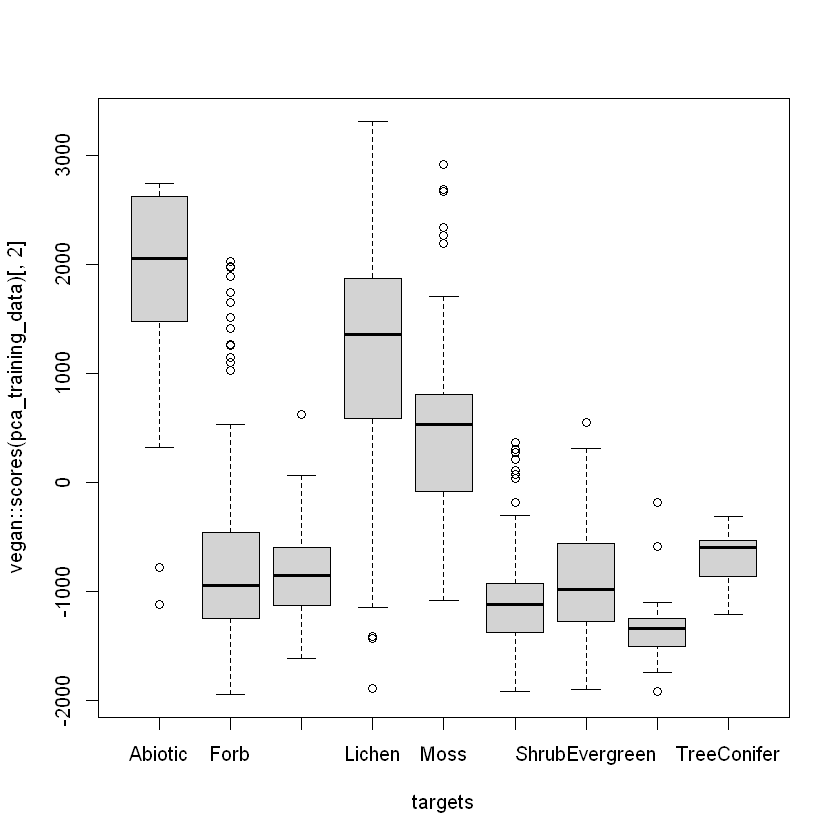

In [101]:
# fit a PCA to the ground spectra
pca_fit <- stats::prcomp(imputed_data[,1:(ncol(numeric_data) - 66)], center = FALSE, scale. = FALSE)
print(summary(pca_fit))
pca_training_data <- predict(pca_fit, imputed_data[,1:(ncol(numeric_data) - 66)])[,1:64]
boxplot(vegan::scores(pca_training_data)[,2]~targets)

## Standardization
This cell standardizes the input to center at zero with standard deviation one.

In [102]:
# standardization
indice_standardizer <- caret::preProcess(imputed_data[,1:95])
standardized_indices <- predict(indice_standardizer, imputed_data[,1:95])

val_standardizer <- caret::preProcess(validation_indices)
standardized_validation <- predict(val_standardizer, validation_indices)

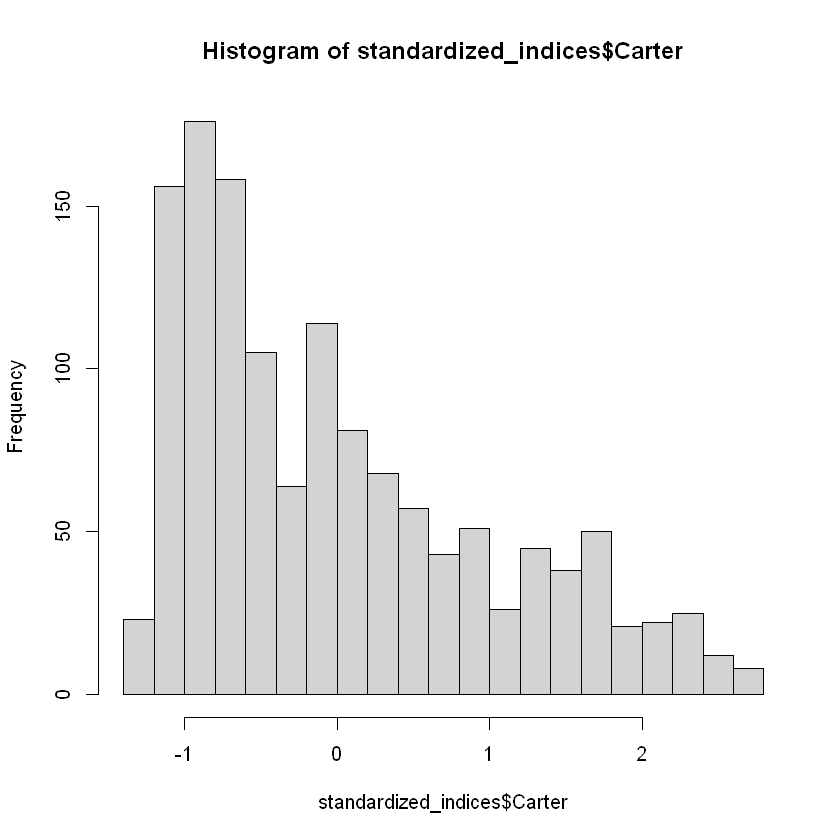

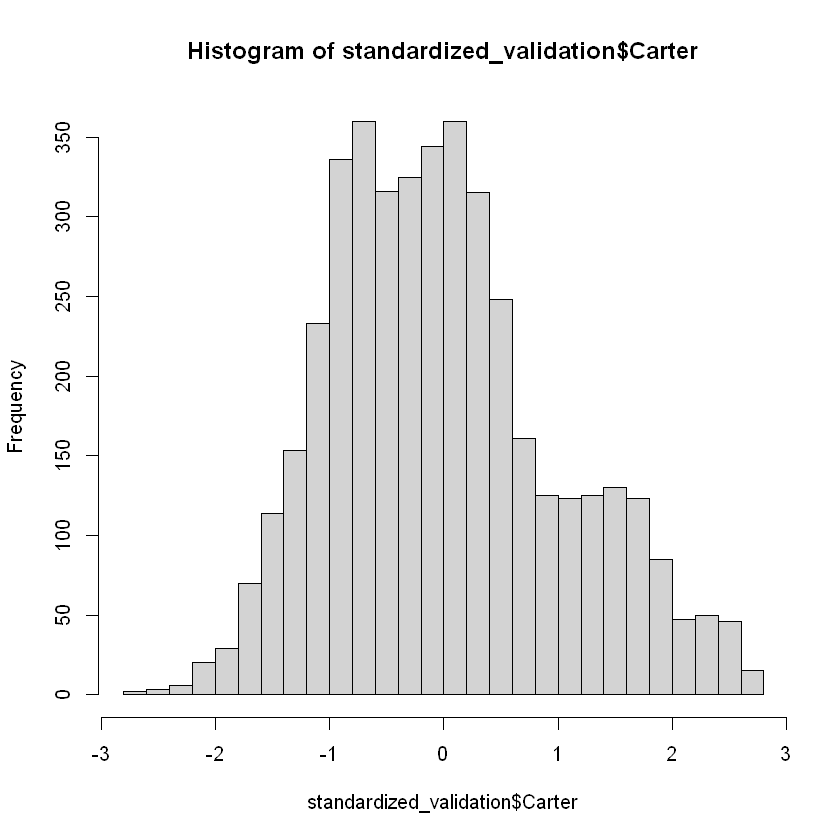

In [99]:
hist(standardized_indices$Carter, breaks = 20)
hist(standardized_validation$Carter, breaks = 20)

## Min-Max Scaling
This executes the min-man scalaing (to make the data on the scale [0,1])

In [113]:
# plots
#hist(min_max_scaled_validation %>% as.matrix())
#hist(min_max_scaled_data %>% as.matrix())
print(colnames(validation_indices))
print(str(pca_fit))
#pca_validation_data <- predict(pca_fit, validation_indices)[,1:64] %>% as.data.frame()
#boxplot(vegan::scores(pca_validation_data)[,2]~validation_labels)

 [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
 [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
[11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
[16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
[21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
[26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
[31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
[36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
[41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
[46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
[51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
[56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
[61] "PARS"         "PRI"          "PRIC

## KS Tests of Transferrability
These next few cells test whether the veg indices are similarly distributed (i.e. could be samples drawn from the same distribution)

The hypothesis is that columns (veg indices) that pass this test can safely be used across models and conditions (are transferrable)

In [114]:
source("Functions/lecospectR.R")
ks_test_results <- test_transferrability(min_max_scaled_data, min_max_scaled_validation)
print(ks_test_results)

Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate in the presence of ties"
Warning message in ks.test.default(df1[, col], df2[, col]):
"p-value will be approximate

$Boochs

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.19584, p-value < 2.2e-16
alternative hypothesis: two-sided


$Boochs2

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.35595, p-value < 2.2e-16
alternative hypothesis: two-sided


$CARI

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.13392, p-value = 2.22e-16
alternative hypothesis: two-sided


$Carter

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.42314, p-value < 2.2e-16
alternative hypothesis: two-sided


$Carter2

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.35641, p-value < 2.2e-16
alternative hypothesis: two-sided


$Carter3

	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df1[, col] and df2[, col]
D = 0.38668, p-value < 2.2e-16
alternative hypothesis: two-sided


$Carter4

	Asymptotic two-sample Kolmogorov-Smirnov test

## t-SNE
Examine the clusters in the data via *t*-SNE

 [1] "N"                   "Y"                   "costs"              
 [4] "itercosts"           "origD"               "perplexity"         
 [7] "theta"               "max_iter"            "stop_lying_iter"    
[10] "mom_switch_iter"     "momentum"            "final_momentum"     
[13] "eta"                 "exaggeration_factor"


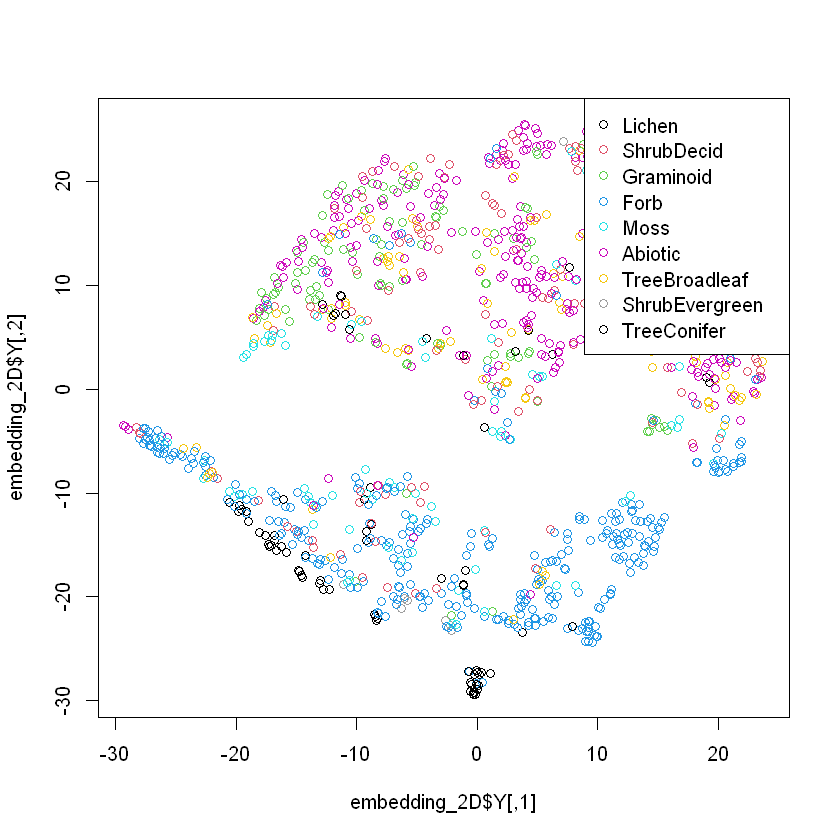

In [115]:
library(Rtsne)
unique_indices <- imputed_data[!duplicated(imputed_data),1:95]
normalized_veg_indices <- Rtsne::normalize_input(
    unique_indices %>% 
    as.matrix()
    )
embedding_2D <- Rtsne::Rtsne(normalized_veg_indices)
print(names(embedding_2D))

plot(embedding_2D$Y, col = as.factor(targets))
par(xpd=T)
legend("topright", legend = unique(targets), col = seq_along(unique(targets)),pch = 1)

## Vector Quantization Classifier
This fits a LVQ classifier to the data and then 

In [116]:
print(length(validation_labels))
print(nrow(min_max_scaled_validation))

[1] 4264
[1] 4264


In [117]:
# method 1 - transfers with 23% accuracy, which is one of the best actually
library(class)
codeBook <-  lvqinit(
    min_max_scaled_data[,1:95], 
    targets, 
10)
code_book_train <- class::olvq1(min_max_scaled_data[,1:95], targets, codeBook)
prediction <- class::lvqtest(code_book_train, min_max_scaled_data[,1:95])
lvq_conf <- caret::confusionMatrix(prediction, targets, mode = "everything")

#print(lvq_conf)

image_prediction <- class::lvqtest(code_book_train, min_max_scaled_validation)

lvq_validation_conf <- caret::confusionMatrix(image_prediction, validation_labels, mode = "everything")



ERROR: Error in confusionMatrix.default(image_prediction, validation_labels, : the data cannot have more levels than the reference


In [ ]:
print(lvq_conf)

In [ ]:
print(lvq_validation_conf)

## Train-Test Split

Perform an 80-20 split on the data (use the split on the fly during the grid search)

In [118]:
grd_train_idx <- caTools::sample.split(targets, SplitRatio = 0.8)

In [119]:
img_train_idx <- caTools::sample.split(validation_labels, SplitRatio = 0.8)

## Random Forest
trains a random forest model

In [120]:

rf_model <- ranger::ranger(
    num.trees = 256,
    case.weights = image_weights,
    importance = "impurity",
    classification = TRUE,
    x = validation_indices,
    y = validation_labels
)

print(rf_model)

Ranger result

Call:
 ranger::ranger(num.trees = 256, case.weights = image_weights,      importance = "impurity", classification = TRUE, x = validation_indices,      y = validation_labels) 

Type:                             Classification 
Number of trees:                  256 
Sample size:                      4264 
Number of independent variables:  95 
Mtry:                             9 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             3.85 % 


In [121]:
predictions <- predict(rf_model, validation_indices)$predictions %>% 
    as.factor()
confusion_matrix <- caret::confusionMatrix(
    predictions, 
    validation_labels, 
    mode = "everything")
print(confusion_matrix)

Confusion Matrix and Statistics

                Reference
Prediction       Abiotic Graminoid Lichen Moss ShrubDecid ShrubEvergreen
  Abiotic            820         0      0    0          0              0
  Graminoid            0       145      0    0          0              0
  Lichen               0         0    155    0          0              0
  Moss                 0         0      0   31          0              0
  ShrubDecid           0         0      0    0        129              0
  ShrubEvergreen       0         0      0    0          0            222
  TreeBroadleaf        0         0      0    0          0              0
  TreeConifer          0         0      0    0          0              0
                Reference
Prediction       TreeBroadleaf TreeConifer
  Abiotic                    0           0
  Graminoid                  0          10
  Lichen                     0           0
  Moss                       0           0
  ShrubDecid                 0           1


In [122]:
save(rf_model, file="mle/models/gs/rf_base_2.rda")

In [123]:
important_variables <- sort(rf_model$variable.importance, decreasing = TRUE)
print(important_variables)

         SR2         PSND        NDVI2         PARS       mND705         mSR2 
  134.482009   113.802768   100.320186    91.539982    85.621014    83.542109 
      mSR705    GreenNDVI          TVI          SR1         GMI2     Gitelson 
   81.735274    72.582798    70.930642    70.081160    68.998607    64.523960 
    Maccioni       ClAInt          SR3    Gitelson2          SR8      Carter3 
   63.550148    61.843624    61.515847    60.577126    59.109765    58.637509 
MCARI2OSAVI2         SPVI         CRI2          SR7           SR         Datt 
   58.511960    58.254919    57.553444    55.989692    55.552384    55.351775 
       NDVI3         MTCI       Carter         NPCI        DWSI4       SumDr2 
   54.966674    54.587809    52.191906    51.903605    51.716430    50.474726 
     Carter6        Datt6        Datt5         GMI1         PSSR    Vogelmann 
   50.415556    50.308513    49.975441    49.423649    48.625105    48.281941 
         SR6      Carter2         SRPI       OSAVI2 

In [124]:
important_variable_names<- names(important_variables)
print(important_variable_names)

 [1] "SR2"          "PSND"         "NDVI2"        "PARS"         "mND705"      
 [6] "mSR2"         "mSR705"       "GreenNDVI"    "TVI"          "SR1"         
[11] "GMI2"         "Gitelson"     "Maccioni"     "ClAInt"       "SR3"         
[16] "Gitelson2"    "SR8"          "Carter3"      "MCARI2OSAVI2" "SPVI"        
[21] "CRI2"         "SR7"          "SR"           "Datt"         "NDVI3"       
[26] "MTCI"         "Carter"       "NPCI"         "DWSI4"        "SumDr2"      
[31] "Carter6"      "Datt6"        "Datt5"        "GMI1"         "PSSR"        
[36] "Vogelmann"    "SR6"          "Carter2"      "SRPI"         "OSAVI2"      
[41] "EVI"          "MCARI2"       "TCARI2OSAVI2" "CI2"          "MTVI"        
[46] "TCARI2"       "GDVI2"        "RDVI"         "MSAVI"        "MPRI"        
[51] "OSAVI"        "GDVI4"        "TGI"          "Vogelmann4"   "CRI1"        
[56] "Carter4"      "GDVI3"        "GI"           "DDn"          "SAVI"        
[61] "Vogelmann2"   "CRI3"         "NDVI

In [125]:
# generate the test data
set.seed(61718L)
permutation <- permute::shuffle(validation_labels)
val_t_chars <- validation_labels[permutation] %>% as.character()
print(val_t_chars[1:5])
counts <- c(0,0,0,0,0,0,0,0,0)
samples <- vector(mode = "logical", length=length(validation_labels))

for(i in seq_along(val_t_chars)){
    samples[[i]] <- FALSE
    if(val_t_chars[[i]] == "Abiotic"){
        if(counts[[1]]<31){
            samples[[i]] <-  TRUE
            counts[[1]] <- counts[[1]] + 1
        }

    } else if (val_t_chars[[i]] == "Graminoid"){
        if(counts[[2]] < 31){
            samples[[i]] <-  TRUE
            counts[[2]] <- counts[[2]] + 1
        }
    } else if (val_t_chars[[i]] == "Forb"){
        if(counts[[3]] < 31){
            samples[[i]] <-  TRUE
            counts[[3]] <- counts[[3]] + 1
        }
    } else if (val_t_chars[[i]] == "Lichen"){
        if(counts[[4]] < 31){
            samples[[i]] <-  TRUE
            counts[[4]] <- counts[[4]] + 1
        }
    } else if (val_t_chars[[i]] == "Moss"){
        if(counts[[5]] < 31){
            samples[[i]] <-  TRUE
            counts[[5]] <- counts[[5]] + 1
        }
    } else if (val_t_chars[[i]] == "ShrubDecid"){
        if(counts[[6]] < 31){
            samples[[i]] <-  TRUE
            counts[[6]] <- counts[[6]] + 1
        }
    } else if (val_t_chars[[i]] == "ShrubEvergreen"){
        if(counts[[7]] < 31){
            samples[[i]] <-  TRUE
            counts[[7]] <- counts[[7]] + 1
        }
    } else if (val_t_chars[[i]] == "TreeConifer"){
        if(counts[[8]] < 31){
            samples[[i]] <-  TRUE
            counts[[8]] <- counts[[8]] + 1
        }
    } else if (val_t_chars[[i]] == "TreeBroadleaf"){
        if(counts[[9]] < 31){
            samples[[i]] <-  TRUE
            counts[[9]] <- counts[[9]] + 1
        }
    }
}


temp <- validation_labels[permutation] %>% as.factor()
test_labels <- temp[as.vector(samples)]
temp <- validation_indices[permutation,] %>% as.data.frame()
test_data <- temp[as.vector(samples),]



[1] "Lichen"         "TreeConifer"    "TreeConifer"    "ShrubEvergreen"
[5] "TreeConifer"   


In [126]:
print(test_labels %>% table())

.
       Abiotic      Graminoid         Lichen           Moss     ShrubDecid 
            31             31             31             31             31 
ShrubEvergreen  TreeBroadleaf    TreeConifer 
            31             31             31 


# Grid Search

This next section defines all the essentials for the grid search across our different candidate models. 

## Candidates

### Models
* Random Forest
* Learned Vector Quantization (LVQ)
* k-Nearest Neighbor (kNN)

Could also consider Support Vector Machine (SVM), Gradient Boosted Trees (e.g. LightGBM, XGBoost), matched filtering, Logistic Regression, etc.

### Data/Transformations

For each of the image/training data sets, test the following:
* raw, 
* raw (no outliers)
* standardized (z-score standardization)
* standardized (z-score standardization, no outliers)
* min-max scaled
* min-max scaled (no outliers)
* PCA
* PCA no outliers

Need to also vary how many columns are included in the analysis

In [127]:
print(dim(imputed_data))
print(dim(standardized_indices))
print(dim(min_max_scaled_data))
print(dim(validation_indices))
print(dim(standardized_validation))
print(dim(min_max_scaled_validation))


[1] 1343  214
[1] 1343   95
[1] 1343  214
[1] 4264   95
[1] 4264   95
[1] 4264   95


In [128]:
print(colnames(imputed_data))

  [1] "Boochs"       "Boochs2"      "CARI"         "Carter"       "Carter2"     
  [6] "Carter3"      "Carter4"      "Carter5"      "Carter6"      "CI"          
 [11] "CI2"          "ClAInt"       "CRI1"         "CRI2"         "CRI3"        
 [16] "CRI4"         "D1"           "D2"           "Datt"         "Datt2"       
 [21] "Datt3"        "Datt4"        "Datt5"        "Datt6"        "DD"          
 [26] "DDn"          "DPI"          "DWSI4"        "EGFN"         "EGFR"        
 [31] "EVI"          "GDVI2"        "GDVI3"        "GDVI4"        "GI"          
 [36] "Gitelson"     "Gitelson2"    "GMI1"         "GMI2"         "GreenNDVI"   
 [41] "Maccioni"     "MCARI"        "MCARIOSAVI"   "MCARI2"       "MCARI2OSAVI2"
 [46] "mND705"       "mNDVI"        "MPRI"         "MSAVI"        "mSR"         
 [51] "mSR2"         "mSR705"       "MTCI"         "MTVI"         "NDVI"        
 [56] "NDVI2"        "NDVI3"        "NPCI"         "OSAVI"        "OSAVI2"      
 [61] "PARS"         "PRI"  

In [ ]:
print(colnames(validation_bands))

In [154]:
# define the data sets to loop over
gs_train <- list(
    #pca_training_data,
    imputed_data,
    scale(imputed_data),
    #standardized_indices[,important_variable_names],
    min_max_scaled_data,
    columnwise_robust_scale(imputed_data)
)

gs_test <- list(
    cbind(validation_indices, validation_bands)[permutation,][samples,],
    cbind(standardized_validation, scale(validation_bands))[permutation,][samples,],
    cbind(min_max_scaled_validation, columnwise_min_max_scale(validation_bands))[permutation,][samples,],
    columnwise_robust_scale(
        cbind(validation_indices, validation_bands)[permutation,][samples,]
    )
    #pca_validation_data[permutation,][samples,],
#    min_max_scaled_validation[permutation,][samples,],
 #   standardized_validation[permutation,][samples,]
    #pca_validation_data[-img_train_idx]

)

gs_train_labels <- list(
    targets,
    targets,
    targets,
    targets,
    targets,
    targets
)

gs_samples <- list(
    test_labels,
    test_labels,
    test_labels,
    test_labels,
    test_labels,
    test_labels,
    test_labels
)

In [130]:
gs_methods <- list(
    #"svmLinear",
    #"rmda",
    "RFlda",
    #"adaboost",
    #"xgbLinear",
    #"xgbTree",
    #"xgbDART",
    "svmRadialWeights",
    #"mda",
    "knn",
    #"lda",
    "ranger"
    #"hda"# heteroscedastic discriminant analysis
)
# add: PLS-LDA, kNN, SVM+poly Kernel, SVM+Exp Kernel, more boosting, 

In [131]:
gs_weight_text <- c(
    "prior weights",
    NULL
)

gs_weights <- list(
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    weights_by_pft,
    image_weights,
    image_weights,
    image_weights
)

fit_ctrl <- caret::trainControl(
    method = "repeatedcv",
    number = 10,
    repeats = 10,
    #classProbs = TRUE,
    allowParallel = TRUE
)

In [157]:
getwd()

[1] "M:/lecospec/lecospec"

In [155]:
for(i in seq_along(gs_train)){
    df <- data.frame(gs_train[[i]])
    test_df <- gs_test[[i]]
        
    # train and print intermediate results to console
    print("Beginning Training")
    model <- ranger::ranger(
        num.trees = 1000,
        case.weights = weights_by_pft,
        classification = TRUE,
        x=df,
        y=gs_train_labels[[i]]
    )
    print(model)

    model_predictions <- predict(
        model, 
        test_df
    )$prediction %>% as.factor()
    
    test_samples <- gs_samples[[i]] %>% as.factor()
    levels(test_samples) <- c(levels(test_samples), "Forb")

    confusion_matrix <- caret::confusionMatrix(
        model_predictions, 
        test_samples,
        mode = "everything"
    )

    model_id <- uuid::UUIDgenerate()

    # append performance data to the logs for later comparison
    sink(file = "mle/log_rf_bv.txt", append = TRUE)
    print("-------------------------------------------------------")
    print("---------------------- Model Data ---------------------")
    
    print(paste0("Model Type: Ranger (Random Forest)"))
    print(paste0("Data Index: ",i))
    print(paste0("Model UUID: ", model_id))
    print("---------------------- Confusion Matrix ---------------------")
    print(confusion_matrix)
    print("---------------------- Class Distribution ---------------------")
    print(model_predictions %>% as.factor() %>% table())
    print("-------------------------------------------------------")
    sink(NULL)

    
    save(model, file = paste0("mle/models/gs/", model_id, ".rda"))


    
}

[1] "Beginning Training"
Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             18.67 % 


Warning message in confusionMatrix.default(model_predictions, test_samples, mode = "everything"):
"Levels are not in the same order for reference and data. Refactoring data to match."


[1] "Beginning Training"
Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             18.86 % 


Warning message in confusionMatrix.default(model_predictions, test_samples, mode = "everything"):
"Levels are not in the same order for reference and data. Refactoring data to match."


[1] "Beginning Training"
Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             18.48 % 


Warning message in confusionMatrix.default(model_predictions, test_samples, mode = "everything"):
"Levels are not in the same order for reference and data. Refactoring data to match."


[1] "Beginning Training"
Ranger result

Call:
 ranger::ranger(num.trees = 1000, case.weights = weights_by_pft,      classification = TRUE, x = df, y = gs_train_labels[[i]]) 

Type:                             Classification 
Number of trees:                  1000 
Sample size:                      1343 
Number of independent variables:  214 
Mtry:                             14 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             18.25 % 


Warning message in confusionMatrix.default(model_predictions, test_samples, mode = "everything"):
"Levels are not in the same order for reference and data. Refactoring data to match."


In [133]:
source("Functions/lecospectR.R")

In [134]:
columnwise_robust_scale(imputed_data)

Boochs,Boochs2,CARI,Carter,Carter2,Carter3,Carter4,Carter5,Carter6,CI,⋯,X942.593_5nm,X947.593_5nm,X952.593_5nm,X957.593_5nm,X962.593_5nm,X967.593_5nm,X972.593_5nm,X977.593_5nm,X982.593_5nm,X987.593_5nm
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.76846038,-0.5372457,-0.223839341,0.82860142,0.7968179,0.8280780,0.5424116,-0.58558127,0.10228073,-0.483739370,⋯,-0.96357607,-0.95561661,-0.95858820,-0.95467969,-0.95168501,-0.94915683,-0.94150565,-0.92280261,-0.91167176,-0.90693523
-0.77454231,-0.5357571,-0.497400716,0.20830885,0.7089907,0.8371099,0.4795027,-0.60310573,-0.08868438,-0.491678568,⋯,-1.20683934,-1.20066382,-1.20826187,-1.20661356,-1.20245826,-1.20058850,-1.19213686,-1.17423709,-1.16567042,-1.16210811
-0.61829558,-0.5015597,0.143341173,1.04278327,0.8080617,0.9767590,0.5872815,-0.61425243,0.76249312,-0.479349708,⋯,-0.71323887,-0.70725207,-0.70840182,-0.70105880,-0.69766267,-0.69602328,-0.69357473,-0.68020578,-0.67310516,-0.67270010
-0.58222254,-0.4895930,0.216628247,1.06494681,0.7768125,0.9598887,0.5500888,-0.62139350,0.92981870,-0.495102400,⋯,-0.60299473,-0.59679494,-0.59723132,-0.59117423,-0.59033874,-0.58962309,-0.58940618,-0.57935405,-0.57535839,-0.57765872
-0.64414051,-0.4981934,-0.017557868,1.07477002,0.7739031,0.9333435,0.5577039,-0.62324396,0.53382029,-0.506770098,⋯,-0.84101020,-0.83532197,-0.83841809,-0.83354997,-0.83124788,-0.83046003,-0.82606724,-0.80944130,-0.79898470,-0.79492490
0.41639104,0.6360243,-0.362385295,-0.49844004,-0.3367462,-0.3251712,-0.5374065,0.04064202,-0.26429102,-0.660619655,⋯,0.04610180,0.05018974,0.05414438,0.06015063,0.05554022,0.05853180,0.05455537,0.05804974,0.05755983,0.04950531
0.33146638,0.7183512,-0.133186270,0.49422873,-0.3758320,-0.3831287,-0.6859238,0.67551949,-0.46207357,0.506543753,⋯,0.48143322,0.49416407,0.52625527,0.57013885,0.60457280,0.65014300,0.67276928,0.68814653,0.69822348,0.70261233
0.17635756,0.6621759,-0.238851721,0.43441272,-0.3961852,-0.3977763,-0.7502802,0.79741660,-0.53480247,0.670928120,⋯,0.33645926,0.34406894,0.36410565,0.39322464,0.41358188,0.44546943,0.46273110,0.48096323,0.49539891,0.50251194
0.01310026,0.6736853,-0.548991612,0.29174428,-0.3920786,-0.4007978,-0.8193800,0.15422791,-0.60720397,0.032833458,⋯,0.44100477,0.44249180,0.46488120,0.50538831,0.53948615,0.58354551,0.60765550,0.62891711,0.64554217,0.65455262


In [108]:
model_ids <- c(
    "2303a2d3-f479-48b7-9840-c9f74b73836d",# ranger subset 10 >0.4
    "6b0a0987-ff68-4f17-a3ca-7aa56284d726",# RFLDA >0.45, subset 11
    "9f8fcf59-571d-4472-8750-7370692a2794",#RFLDA
    "ab537b5-5141-4381-a464-5a0ff6cde137",#SVM
    #"58bee4bd-ea18-4fdb-823a-21463be3da41",#KNN predictions failed, may be clash with parallel pkg
    "cf2b9f30-4956-4c0b-a1fe-79af7590cac9",#Ranger
    "0c63dd43-79fe-45dd-b95f-ac8d6b2d7265",#Ranger, subset 1
    #"f7d408d7-5cd5-4214-b31c-ec8f75e197dc",# SVM, subset 3 <- issue, re-run
    "e335d595-c095-4356-b967-d15c37479527",# ranger all
    #"b80328dd-9c40-4e99-8a9f-239121931fb4",# ranger subset 8
    #"f8ad4263-8470-43db-856b-4476dfc83ccc",# ranger subset 7
    #"1cd97e42-f7e1-4580-928b-1a42609a6549",# Ranger subset 5
    #"2b9d4a04-0586-4743-83ff-39e77a7345c7",#ranger subset 11
    "6c3bedc5-11ae-423e-a858-13240650f14b",#RF-LDA substet 5
    #"f362ade9-43cd-4342-b62d-8f2f1d5c50b5",#RFLDA subset 9 <- this particular model returns all NAs???
    #"9c496675-d6b4-46d1-a3cc-4da9f69c702",# ranger subset 12, ~.4 <- wrong path
    "rf_base",
    #"44e2506d-a587-4a27-acbb-1842f9fb421a",# SVM all
    #"02cdc9a4-2265-432b-8010-170048a94c01",# kNN, Subset 3
    #"7707394d-5755-4bf5-a8c9-e9f8d08e0aa8",# SVM, subset 4
    #"53bb89e1-22a9-4199-ac24-22232063dd79",# SVM subset 6
    #"cdb0d9c9-3f3e-4c3a-8277-336cc58fcaa8",# svm subset 7
    #"bef61c5e-9458-41df-9ce5-a30e45299e8f",# svm subset 10
    #"af392d97-067b-4391-8577-ead82f84fc08"#knn subset 12
    #"e335392b-73af-478d-a7f8-e3eaacea9774",#knn, subset 1 <- predictions failed, re-run
    ##"d41050ba-04b4-4507-a21e-d3743f59b793"
    #"5059eb96-fe79-43b7-bcc6-9dd54fbc3e83",
    #"654ae09e-666d-4eee-90a7-008b9b34b147",
    #"7920d1b5-4fc7-4ba0-b282-23fbecbc889a"

"31940dfa-a053-4398-b240-a33c768e5075"
)

#for(id in model_ids){
    id <- "dd74d8f9-50db-4f0c-a1fb-bfa85ae90074"
    model <- load_model(
        paste0("mle/models/gs/", id, ".rda")
    )

    save_path <- paste0("mle/experiments/gs/", id, "/")
    #print(names(model))
print(model)
    if(!dir.exists(save_path)){
        dir.create(save_path)
    }
    #print(quadrats[[3]])


#tile_results <- process_tile(
#            quadrats[[1]],
#            model,
#            1,
#            cluster = NULL,
#            return_raster = TRUE,
#            band_names = band_names,
#            normalize_input = normalize_input,
#            scale_input = scale_input,
#            robust_scale_input = robust_scale_input,
#            standardize_input = standardize_input,
#            save_path = "./validation_saved_output.grd",
#            suppress_output = FALSE)
#            print(tile_results)
   results <- validate_model(
       model, 
       save_path, 
       normalize_input = FALSE,
       standardize_input = TRUE,
       scale_input = FALSE,
       robust_scale_input = FALSE, 
       cluster = NULL)
   aggregated_results <- aggregate_results(save_path)

    plot_by_pft(
        aggregated_results,
        save_path = paste0(save_path, "aggregate.html"),
        open = FALSE
    )
#
    write_validation_table(
        aggregated_results,
        save_path = paste0(save_path, "table.html"),
        open = FALSE
    )

    
#}

 [1] "method"       "modelInfo"    "modelType"    "results"      "pred"        
 [6] "bestTune"     "call"         "dots"         "metric"       "control"     
[11] "finalModel"   "preProcess"   "trainingData" "ptype"        "resample"    
[16] "resampledCM"  "perfNames"    "maximize"     "yLimits"      "times"       
[21] "levels"       "terms"        "coefnames"    "xlevels"     
[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/BisonGulchQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.9508 63.80701 4
2 -148.9508 63.80701 4
3 -148.9508 63.80701 4
4 -148.9508 63.80701 4
5 -148.9508 63.80701 4
6 -148.9508 63.80701 4
          x        y z
1 -148.9508 63.80701 4
2 -148.9508 63.80701 4
3 -148.9508 63.80701 4
4 -148.9508 63.80701 4
5 -148.9508 63.80701 4
6 -148.9508 63.80701 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `Bisoon_Quadrats_georeferenced' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/Bisoon_Quadrats_georeferenced.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 9 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9524 ymin: 63.80698 xmax: -148.9508 ymax: 63.80701
Geodetic CRS:  WGS 84
[1] "Bisongulch0"  "Bisongulch70" "Bisongulch80" "Bisongulch10" "Bisongulch90"
[6] "Bisongulch20" "Bisongulch50" "Bisongulch30" "Bisongulch40"
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
D

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.952 ymin: 63.80699 xmax: -148.952 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        7 Bisongulch70  649 POLYGON ((-148.952 63.80699...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9522 ymin: 63.80699 xmax: -148.9522 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        8 Bisongulch80  661 POLYGON ((-148.9522 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.951 ymin: 63.80699 xmax: -148.9509 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        2 Bisongulch10  649 POLYGON ((-148.9509 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9524 ymin: 63.80699 xmax: -148.9524 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
5        9 Bisongulch90  648 POLYGON ((-148.9524 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9512 ymin: 63.80699 xmax: -148.9512 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
6        3 Bisongulch20  574 POLYGON ((-148.9512 63.8069...


Warning message in readChar(con, 5L, useBytes = TRUE):
"cannot open compressed file 'mle/models/gs/7eed8a52-eb0b-4083-b3cc-d0b9e5df7d8b.rda', probable reason 'No such file or directory'"


ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/ChatanikaQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -147.4827 65.15287 4
2 -147.4827 65.15287 4
3 -147.4827 65.15287 4
4 -147.4827 65.15287 4
5 -147.4827 65.15287 4
6 -147.4827 65.15287 4
          x        y z
1 -147.4827 65.15287 4
2 -147.4827 65.15287 4
3 -147.4827 65.15287 4
4 -147.4827 65.15287 4
5 -147.4827 65.15287 4
6 -147.4827 65.15287 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `ChatanikaQuads_georeferenced' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/ChatanikaQuads_georeferenced.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 11 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4827 ymin: 65.15281 xmax: -147.4806 ymax: 65.15287
Geodetic CRS:  WGS 84
 [1] "Chatanika100" "Chatanika90"  "Chatanika70"  "Chatanika80"  "Chatanika60" 
 [6] "Chatanika50"  "Chatanika40"  "Chatanika30"  "Chatanika20"  "Chatanika10" 
[11] "Chatanika0"  
Simple feature collection with 1 feature a

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4825 ymin: 65.15285 xmax: -147.4825 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Chatanika90       10    0,255,0 POLYGON ((-147.4825 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4821 ymin: 65.15285 xmax: -147.4821 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Chatanika70        8  0,128,128 POLYGON ((-147.4821 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4823 ymin: 65.15285 xmax: -147.4823 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Chatanika80        9    128,0,0 POLYGON ((-147.4823 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4819 ymin: 65.15285 xmax: -147.4819 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Chatanika60        7  128,128,0 POLYGON ((-147.4819 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4817 ymin: 65.15284 xmax: -147.4816 ymax: 65.15285
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6 Chatanika50        6  255,0,255 POLYGON ((-147.4816 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4815 ymin: 65.15283 xmax: -147.4814 ymax: 65.15284
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7 Chatanika40        5  0,255,255 POLYGON ((-147.4814 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4812 ymin: 65.15282 xmax: -147.4812 ymax: 65.15283
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8 Chatanika30        4  255,255,0 POLYGON ((-147.4812 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.481 ymin: 65.15281 xmax: -147.481 ymax: 65.15282
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9 Chatanika20        3    0,0,255 POLYGON ((-147.481 65.15282...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4808 ymin: 65.15281 xmax: -147.4808 ymax: 65.15282
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10 Chatanika10        2    0,128,0 POLYGON ((-147.4808 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4806 ymin: 65.15281 xmax: -147.4806 ymax: 65.15281
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11 Chatanika0        1    255,0,0 POLYGON ((-147.4806 65.1528...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/TwelveMileGulchQuads1.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


         x        y z
1 -145.979 65.40191 6
2 -145.979 65.40191 6
3 -145.979 65.40191 5
4 -145.979 65.40191 5
5 -145.979 65.40191 4
6 -145.979 65.40191 6
         x        y z
1 -145.979 65.40191 6
2 -145.979 65.40191 6
3 -145.979 65.40191 5
4 -145.979 65.40191 5
5 -145.979 65.40191 4
6 -145.979 65.40191 6
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `TwelveMileQ0_10_20_30_40m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/TwelveMileQ0_10_20_30_40m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 5 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.979 ymin: 65.4018 xmax: -145.9782 ymax: 65.40191
Geodetic CRS:  WGS 84
[1] "Twelvemile40" "Twelvemile30" "Twelvemile20" "Twelvemile10" "Twelvemile0" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.979 ymin: 65.4019 xmax: -145.979 ymax: 65.401

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9788 ymin: 65.40187 xmax: -145.9788 ymax: 65.40188
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        1 Twelvemile30  281 POLYGON ((-145.9788 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9786 ymin: 65.40185 xmax: -145.9786 ymax: 65.40186
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        2 Twelvemile20  328 POLYGON ((-145.9786 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9784 ymin: 65.40183 xmax: -145.9784 ymax: 65.40184
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        3 Twelvemile10  308 POLYGON ((-145.9784 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9782 ymin: 65.4018 xmax: -145.9782 ymax: 65.40181
Geodetic CRS:  GCS_unknown
  CLASS_ID  CLASS_NAME AREA                       geometry
5        5 Twelvemile0  336 POLYGON ((-145.9782 65.4018...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/TwelveMileGulchQuads2.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -145.9802 65.40203 4
2 -145.9802 65.40203 4
3 -145.9802 65.40203 6
4 -145.9802 65.40203 6
5 -145.9802 65.40203 4
6 -145.9802 65.40203 4
          x        y z
1 -145.9802 65.40203 4
2 -145.9802 65.40203 4
3 -145.9802 65.40203 6
4 -145.9802 65.40203 6
5 -145.9802 65.40203 4
6 -145.9802 65.40203 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `TwelveMileQ70_80_90_100m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/TwelveMileQ70_80_90_100m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 4 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9802 ymin: 65.40196 xmax: -145.9796 ymax: 65.40203
Geodetic CRS:  WGS 84
[1] "Twelvemile100" "Twelvemile90"  "Twelvemile80"  "Twelvemile70" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9802 ymin: 65.40202 xmax: -145.9802 ymax: 

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.98 ymin: 65.402 xmax: -145.98 ymax: 65.40201
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        3 Twelvemile90  473 POLYGON ((-145.98 65.402, -...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9798 ymin: 65.40198 xmax: -145.9798 ymax: 65.40199
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        2 Twelvemile80  631 POLYGON ((-145.9798 65.4019...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9796 ymin: 65.40196 xmax: -145.9796 ymax: 65.40197
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        1 Twelvemile70  518 POLYGON ((-145.9796 65.4019...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/EightMileQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -149.2529 63.87686 4
2 -149.2529 63.87686 4
3 -149.2529 63.87686 4
4 -149.2529 63.87686 4
5 -149.2529 63.87686 4
6 -149.2529 63.87686 4
          x        y z
1 -149.2529 63.87686 4
2 -149.2529 63.87686 4
3 -149.2529 63.87686 4
4 -149.2529 63.87686 4
5 -149.2529 63.87686 4
6 -149.2529 63.87686 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `EightMile_Quadrats_revised' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/EightMile_Quadrats_revised.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 11 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2549 ymin: 63.87666 xmax: -149.2529 ymax: 63.87686
Geodetic CRS:  WGS 84
 [1] "Eightmile10"  "Eightmile0"   "Eightmile60"  "Eightmile50"  "Eightmile40" 
 [6] "Eightmile30"  "Eightmile20"  "Eightmile100" "Eightmile90"  "Eightmile80" 
[11] "Eightmile70" 
Simple feature collection with 1 feature and 3

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2549 ymin: 63.87666 xmax: -149.2548 ymax: 63.87667
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Eightmile0        1    255,0,0 POLYGON ((-149.2548 63.8766...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2537 ymin: 63.87675 xmax: -149.2537 ymax: 63.87677
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Eightmile60        7  128,128,0 POLYGON ((-149.2537 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2539 ymin: 63.87673 xmax: -149.2539 ymax: 63.87674
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Eightmile50        6  255,0,255 POLYGON ((-149.2539 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2541 ymin: 63.87672 xmax: -149.254 ymax: 63.87673
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Eightmile40        5  0,255,255 POLYGON ((-149.254 63.87673...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2543 ymin: 63.87671 xmax: -149.2542 ymax: 63.87672
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6 Eightmile30        4  255,255,0 POLYGON ((-149.2542 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2545 ymin: 63.87669 xmax: -149.2544 ymax: 63.8767
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7 Eightmile20        3    0,0,255 POLYGON ((-149.2544 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2529 ymin: 63.87685 xmax: -149.2529 ymax: 63.87686
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8 Eightmile100       11    0,255,0 POLYGON ((-149.2529 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2531 ymin: 63.87682 xmax: -149.2531 ymax: 63.87684
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9 Eightmile90       10    128,0,0 POLYGON ((-149.2531 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2533 ymin: 63.8768 xmax: -149.2533 ymax: 63.87681
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10 Eightmile80        9  255,255,0 POLYGON ((-149.2533 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2535 ymin: 63.87678 xmax: -149.2535 ymax: 63.87679
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11 Eightmile70        8  0,128,128 POLYGON ((-149.2535 63.8767...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/MurphDomeQuads0_10.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x       y z
1 -148.3535 64.9538 4
2 -148.3535 64.9538 4
3 -148.3535 64.9538 4
4 -148.3535 64.9538 4
5 -148.3535 64.9538 4
6 -148.3535 64.9538 6
          x       y z
1 -148.3535 64.9538 4
2 -148.3535 64.9538 4
3 -148.3535 64.9538 4
4 -148.3535 64.9538 4
5 -148.3535 64.9538 4
6 -148.3535 64.9538 6
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `MurphyQuads0_10m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/MurphyQuads0_10m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3535 ymin: 64.95372 xmax: -148.3533 ymax: 64.9538
Geodetic CRS:  WGS 84
[1] "Murphydome10" "Murphydome0" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3535 ymin: 64.95379 xmax: -148.3535 ymax: 64.9538
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3534 ymin: 64.95372 xmax: -148.3533 ymax: 64.95373
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome0        2    0,128,0 POLYGON ((-148.3534 64.9537...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/MurphDomeQuads20_50.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.3540 64.95407 6
2 -148.3541 64.95407 4
3 -148.3540 64.95407 6
4 -148.3540 64.95407 4
5 -148.3541 64.95407 6
6 -148.3541 64.95407 4
          x        y z
1 -148.3540 64.95407 6
2 -148.3541 64.95407 4
3 -148.3540 64.95407 6
4 -148.3540 64.95407 4
5 -148.3541 64.95407 6
6 -148.3541 64.95407 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `MurphyQuads20_50m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/MurphyQuads20_50m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 4 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3541 ymin: 64.95384 xmax: -148.3536 ymax: 64.95407
Geodetic CRS:  WGS 84
[1] "Murphydome50" "Murphydome40" "Murphydome30" "Murphydome20"
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3541 ymin: 64.95406 xmax: -148.354 ymax: 64.95407
Geodetic C

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3539 ymin: 64.95399 xmax: -148.3539 ymax: 64.954
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome40        2  255,0,255 POLYGON ((-148.3539 64.954,...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3538 ymin: 64.95392 xmax: -148.3537 ymax: 64.95393
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Murphydome30        3  0,255,255 POLYGON ((-148.3538 64.9539...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3537 ymin: 64.95384 xmax: -148.3536 ymax: 64.95386
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Murphydome20        4  255,255,0 POLYGON ((-148.3536 64.9538...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/MurphDomeQuads60_100.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.3548 64.95441 6
2 -148.3548 64.95441 4
3 -148.3548 64.95441 6
4 -148.3548 64.95441 6
5 -148.3548 64.95441 4
6 -148.3548 64.95441 4
          x        y z
1 -148.3548 64.95441 6
2 -148.3548 64.95441 4
3 -148.3548 64.95441 6
4 -148.3548 64.95441 6
5 -148.3548 64.95441 4
6 -148.3548 64.95441 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `MurphyQuads60_100m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/MurphyQuads60_100m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 5 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3548 ymin: 64.95413 xmax: -148.3542 ymax: 64.95441
Geodetic CRS:  WGS 84
[1] "Murphydome100" "Murphydome90"  "Murphydome80"  "Murphydome70" 
[5] "Murphydome60" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3548 ymin: 64.9544 xmax: -148.3547

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3546 ymin: 64.95433 xmax: -148.3546 ymax: 64.95434
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome90        2    0,0,128 POLYGON ((-148.3546 64.9543...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3545 ymin: 64.95426 xmax: -148.3544 ymax: 64.95427
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Murphydome80        3    0,255,0 POLYGON ((-148.3545 64.9542...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3543 ymin: 64.95419 xmax: -148.3543 ymax: 64.9542
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Murphydome70        4    128,0,0 POLYGON ((-148.3543 64.9542...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3542 ymin: 64.95413 xmax: -148.3542 ymax: 64.95414
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Murphydome60        5  0,128,128 POLYGON ((-148.3542 64.9541...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/BonanzaQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.2962 64.70435 4
2 -148.2962 64.70435 4
3 -148.2962 64.70435 4
4 -148.2962 64.70435 4
5 -148.2962 64.70435 4
6 -148.2962 64.70435 5
          x        y z
1 -148.2962 64.70435 4
2 -148.2962 64.70435 4
3 -148.2962 64.70435 4
4 -148.2962 64.70435 4
5 -148.2962 64.70435 4
6 -148.2962 64.70435 5
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `Bonanza_N_Quads' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/Bonanza_N_Quads.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 11 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 438153.7 ymin: 7176051 xmax: 438205.6 ymax: 7176138
Projected CRS: WGS 84 / UTM zone 6N
 [1] "Bonanza60"  "Bonanza100" "Bonanza90"  "Bonanza80"  "Bonanza50" 
 [6] "Bonanza40"  "Bonanza30"  "Bonanza20"  "Bonanza10"  "Bonanza0"  
[11] "Bonanza70" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dim

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2962 ymin: 64.70434 xmax: -148.2962 ymax: 64.70435
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Bonanza100       11  127,255,0 POLYGON ((-148.2962 64.7043...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2963 ymin: 64.70426 xmax: -148.2963 ymax: 64.70428
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3  Bonanza90       10 255,127,80 POLYGON ((-148.2963 64.7042...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2964 ymin: 64.70418 xmax: -148.2964 ymax: 64.7042
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4  Bonanza80        9    0,0,128 POLYGON ((-148.2964 64.7042...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2967 ymin: 64.70395 xmax: -148.2967 ymax: 64.70396
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5  Bonanza50        6  255,0,255 POLYGON ((-148.2967 64.7039...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2968 ymin: 64.70387 xmax: -148.2968 ymax: 64.70388
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6  Bonanza40        5  0,255,255 POLYGON ((-148.2968 64.7038...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2969 ymin: 64.70379 xmax: -148.2969 ymax: 64.7038
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7  Bonanza30        4  255,255,0 POLYGON ((-148.2969 64.7038...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.297 ymin: 64.70371 xmax: -148.297 ymax: 64.70373
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8  Bonanza20        3    0,0,255 POLYGON ((-148.297 64.70373...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2971 ymin: 64.70364 xmax: -148.2971 ymax: 64.70365
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9  Bonanza10        2    0,128,0 POLYGON ((-148.2971 64.7036...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2972 ymin: 64.70356 xmax: -148.2972 ymax: 64.70357
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10   Bonanza0        1    255,0,0 POLYGON ((-148.2972 64.7035...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2965 ymin: 64.70411 xmax: -148.2965 ymax: 64.70412
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11  Bonanza70        8    0,255,0 POLYGON ((-148.2965 64.7041...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



 [1] "method"       "modelInfo"    "modelType"    "results"      "pred"        
 [6] "bestTune"     "call"         "dots"         "metric"       "control"     
[11] "finalModel"   "preProcess"   "trainingData" "ptype"        "resample"    
[16] "resampledCM"  "perfNames"    "maximize"     "yLimits"      "times"       
[21] "levels"       "terms"        "coefnames"    "xlevels"     
[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/BisonGulchQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.9508 63.80701 3
2 -148.9508 63.80701 3
3 -148.9508 63.80701 3
4 -148.9508 63.80701 3
5 -148.9508 63.80701 3
6 -148.9508 63.80701 3
          x        y z
1 -148.9508 63.80701 3
2 -148.9508 63.80701 3
3 -148.9508 63.80701 3
4 -148.9508 63.80701 3
5 -148.9508 63.80701 3
6 -148.9508 63.80701 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `Bisoon_Quadrats_georeferenced' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/Bisoon_Quadrats_georeferenced.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 9 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9524 ymin: 63.80698 xmax: -148.9508 ymax: 63.80701
Geodetic CRS:  WGS 84
[1] "Bisongulch0"  "Bisongulch70" "Bisongulch80" "Bisongulch10" "Bisongulch90"
[6] "Bisongulch20" "Bisongulch50" "Bisongulch30" "Bisongulch40"
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
D

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.952 ymin: 63.80699 xmax: -148.952 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        7 Bisongulch70  649 POLYGON ((-148.952 63.80699...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9522 ymin: 63.80699 xmax: -148.9522 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        8 Bisongulch80  661 POLYGON ((-148.9522 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.951 ymin: 63.80699 xmax: -148.9509 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        2 Bisongulch10  649 POLYGON ((-148.9509 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9524 ymin: 63.80699 xmax: -148.9524 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
5        9 Bisongulch90  648 POLYGON ((-148.9524 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9512 ymin: 63.80699 xmax: -148.9512 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
6        3 Bisongulch20  574 POLYGON ((-148.9512 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9518 ymin: 63.80699 xmax: -148.9518 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
7        6 Bisongulch50  673 POLYGON ((-148.9518 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9514 ymin: 63.80699 xmax: -148.9514 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
8        4 Bisongulch30  673 POLYGON ((-148.9514 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9516 ymin: 63.80698 xmax: -148.9516 ymax: 63.80699
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
9        5 Bisongulch40  674 POLYGON ((-148.9516 63.8069...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/ChatanikaQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -147.4827 65.15287 3
2 -147.4827 65.15287 3
3 -147.4827 65.15287 3
4 -147.4827 65.15287 3
5 -147.4827 65.15287 3
6 -147.4827 65.15287 3
          x        y z
1 -147.4827 65.15287 3
2 -147.4827 65.15287 3
3 -147.4827 65.15287 3
4 -147.4827 65.15287 3
5 -147.4827 65.15287 3
6 -147.4827 65.15287 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `ChatanikaQuads_georeferenced' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/ChatanikaQuads_georeferenced.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 11 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4827 ymin: 65.15281 xmax: -147.4806 ymax: 65.15287
Geodetic CRS:  WGS 84
 [1] "Chatanika100" "Chatanika90"  "Chatanika70"  "Chatanika80"  "Chatanika60" 
 [6] "Chatanika50"  "Chatanika40"  "Chatanika30"  "Chatanika20"  "Chatanika10" 
[11] "Chatanika0"  
Simple feature collection with 1 feature a

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4825 ymin: 65.15285 xmax: -147.4825 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Chatanika90       10    0,255,0 POLYGON ((-147.4825 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4821 ymin: 65.15285 xmax: -147.4821 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Chatanika70        8  0,128,128 POLYGON ((-147.4821 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4823 ymin: 65.15285 xmax: -147.4823 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Chatanika80        9    128,0,0 POLYGON ((-147.4823 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4819 ymin: 65.15285 xmax: -147.4819 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Chatanika60        7  128,128,0 POLYGON ((-147.4819 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4817 ymin: 65.15284 xmax: -147.4816 ymax: 65.15285
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6 Chatanika50        6  255,0,255 POLYGON ((-147.4816 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4815 ymin: 65.15283 xmax: -147.4814 ymax: 65.15284
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7 Chatanika40        5  0,255,255 POLYGON ((-147.4814 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4812 ymin: 65.15282 xmax: -147.4812 ymax: 65.15283
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8 Chatanika30        4  255,255,0 POLYGON ((-147.4812 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.481 ymin: 65.15281 xmax: -147.481 ymax: 65.15282
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9 Chatanika20        3    0,0,255 POLYGON ((-147.481 65.15282...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4808 ymin: 65.15281 xmax: -147.4808 ymax: 65.15282
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10 Chatanika10        2    0,128,0 POLYGON ((-147.4808 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4806 ymin: 65.15281 xmax: -147.4806 ymax: 65.15281
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11 Chatanika0        1    255,0,0 POLYGON ((-147.4806 65.1528...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/TwelveMileGulchQuads1.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


         x        y z
1 -145.979 65.40191 3
2 -145.979 65.40191 3
3 -145.979 65.40191 3
4 -145.979 65.40191 3
5 -145.979 65.40191 3
6 -145.979 65.40191 3
         x        y z
1 -145.979 65.40191 3
2 -145.979 65.40191 3
3 -145.979 65.40191 3
4 -145.979 65.40191 3
5 -145.979 65.40191 3
6 -145.979 65.40191 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `TwelveMileQ0_10_20_30_40m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/TwelveMileQ0_10_20_30_40m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 5 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.979 ymin: 65.4018 xmax: -145.9782 ymax: 65.40191
Geodetic CRS:  WGS 84
[1] "Twelvemile40" "Twelvemile30" "Twelvemile20" "Twelvemile10" "Twelvemile0" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.979 ymin: 65.4019 xmax: -145.979 ymax: 65.401

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9788 ymin: 65.40187 xmax: -145.9788 ymax: 65.40188
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        1 Twelvemile30  281 POLYGON ((-145.9788 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9786 ymin: 65.40185 xmax: -145.9786 ymax: 65.40186
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        2 Twelvemile20  328 POLYGON ((-145.9786 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9784 ymin: 65.40183 xmax: -145.9784 ymax: 65.40184
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        3 Twelvemile10  308 POLYGON ((-145.9784 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9782 ymin: 65.4018 xmax: -145.9782 ymax: 65.40181
Geodetic CRS:  GCS_unknown
  CLASS_ID  CLASS_NAME AREA                       geometry
5        5 Twelvemile0  336 POLYGON ((-145.9782 65.4018...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/TwelveMileGulchQuads2.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -145.9802 65.40203 3
2 -145.9802 65.40203 3
3 -145.9802 65.40203 3
4 -145.9802 65.40203 3
5 -145.9802 65.40203 3
6 -145.9802 65.40203 3
          x        y z
1 -145.9802 65.40203 3
2 -145.9802 65.40203 3
3 -145.9802 65.40203 3
4 -145.9802 65.40203 3
5 -145.9802 65.40203 3
6 -145.9802 65.40203 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `TwelveMileQ70_80_90_100m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/TwelveMileQ70_80_90_100m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 4 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9802 ymin: 65.40196 xmax: -145.9796 ymax: 65.40203
Geodetic CRS:  WGS 84
[1] "Twelvemile100" "Twelvemile90"  "Twelvemile80"  "Twelvemile70" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9802 ymin: 65.40202 xmax: -145.9802 ymax: 

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.98 ymin: 65.402 xmax: -145.98 ymax: 65.40201
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        3 Twelvemile90  473 POLYGON ((-145.98 65.402, -...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9798 ymin: 65.40198 xmax: -145.9798 ymax: 65.40199
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        2 Twelvemile80  631 POLYGON ((-145.9798 65.4019...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9796 ymin: 65.40196 xmax: -145.9796 ymax: 65.40197
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        1 Twelvemile70  518 POLYGON ((-145.9796 65.4019...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/EightMileQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -149.2529 63.87686 3
2 -149.2529 63.87686 3
3 -149.2529 63.87686 3
4 -149.2529 63.87686 3
5 -149.2529 63.87686 3
6 -149.2529 63.87686 3
          x        y z
1 -149.2529 63.87686 3
2 -149.2529 63.87686 3
3 -149.2529 63.87686 3
4 -149.2529 63.87686 3
5 -149.2529 63.87686 3
6 -149.2529 63.87686 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `EightMile_Quadrats_revised' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/EightMile_Quadrats_revised.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 11 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2549 ymin: 63.87666 xmax: -149.2529 ymax: 63.87686
Geodetic CRS:  WGS 84
 [1] "Eightmile10"  "Eightmile0"   "Eightmile60"  "Eightmile50"  "Eightmile40" 
 [6] "Eightmile30"  "Eightmile20"  "Eightmile100" "Eightmile90"  "Eightmile80" 
[11] "Eightmile70" 
Simple feature collection with 1 feature and 3

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2549 ymin: 63.87666 xmax: -149.2548 ymax: 63.87667
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Eightmile0        1    255,0,0 POLYGON ((-149.2548 63.8766...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2537 ymin: 63.87675 xmax: -149.2537 ymax: 63.87677
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Eightmile60        7  128,128,0 POLYGON ((-149.2537 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2539 ymin: 63.87673 xmax: -149.2539 ymax: 63.87674
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Eightmile50        6  255,0,255 POLYGON ((-149.2539 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2541 ymin: 63.87672 xmax: -149.254 ymax: 63.87673
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Eightmile40        5  0,255,255 POLYGON ((-149.254 63.87673...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2543 ymin: 63.87671 xmax: -149.2542 ymax: 63.87672
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6 Eightmile30        4  255,255,0 POLYGON ((-149.2542 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2545 ymin: 63.87669 xmax: -149.2544 ymax: 63.8767
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7 Eightmile20        3    0,0,255 POLYGON ((-149.2544 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2529 ymin: 63.87685 xmax: -149.2529 ymax: 63.87686
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8 Eightmile100       11    0,255,0 POLYGON ((-149.2529 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2531 ymin: 63.87682 xmax: -149.2531 ymax: 63.87684
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9 Eightmile90       10    128,0,0 POLYGON ((-149.2531 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2533 ymin: 63.8768 xmax: -149.2533 ymax: 63.87681
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10 Eightmile80        9  255,255,0 POLYGON ((-149.2533 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2535 ymin: 63.87678 xmax: -149.2535 ymax: 63.87679
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11 Eightmile70        8  0,128,128 POLYGON ((-149.2535 63.8767...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/MurphDomeQuads0_10.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x       y z
1 -148.3535 64.9538 3
2 -148.3535 64.9538 3
3 -148.3535 64.9538 3
4 -148.3535 64.9538 3
5 -148.3535 64.9538 3
6 -148.3535 64.9538 3
          x       y z
1 -148.3535 64.9538 3
2 -148.3535 64.9538 3
3 -148.3535 64.9538 3
4 -148.3535 64.9538 3
5 -148.3535 64.9538 3
6 -148.3535 64.9538 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `MurphyQuads0_10m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/MurphyQuads0_10m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3535 ymin: 64.95372 xmax: -148.3533 ymax: 64.9538
Geodetic CRS:  WGS 84
[1] "Murphydome10" "Murphydome0" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3535 ymin: 64.95379 xmax: -148.3535 ymax: 64.9538
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3534 ymin: 64.95372 xmax: -148.3533 ymax: 64.95373
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome0        2    0,128,0 POLYGON ((-148.3534 64.9537...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/MurphDomeQuads20_50.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y  z
1 -148.3540 64.95407 NA
2 -148.3541 64.95407  3
3 -148.3540 64.95407  3
4 -148.3540 64.95407  3
5 -148.3541 64.95407  3
6 -148.3541 64.95407  3
          x        y  z
1 -148.3540 64.95407 NA
2 -148.3541 64.95407  3
3 -148.3540 64.95407  3
4 -148.3540 64.95407  3
5 -148.3541 64.95407  3
6 -148.3541 64.95407  3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `MurphyQuads20_50m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/MurphyQuads20_50m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 4 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3541 ymin: 64.95384 xmax: -148.3536 ymax: 64.95407
Geodetic CRS:  WGS 84
[1] "Murphydome50" "Murphydome40" "Murphydome30" "Murphydome20"
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3541 ymin: 64.95406 xmax: -148.354 ymax: 64.95

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3539 ymin: 64.95399 xmax: -148.3539 ymax: 64.954
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome40        2  255,0,255 POLYGON ((-148.3539 64.954,...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3538 ymin: 64.95392 xmax: -148.3537 ymax: 64.95393
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Murphydome30        3  0,255,255 POLYGON ((-148.3538 64.9539...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3537 ymin: 64.95384 xmax: -148.3536 ymax: 64.95386
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Murphydome20        4  255,255,0 POLYGON ((-148.3536 64.9538...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/MurphDomeQuads60_100.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.3548 64.95441 3
2 -148.3548 64.95441 3
3 -148.3548 64.95441 3
4 -148.3548 64.95441 3
5 -148.3548 64.95441 3
6 -148.3548 64.95441 3
          x        y z
1 -148.3548 64.95441 3
2 -148.3548 64.95441 3
3 -148.3548 64.95441 3
4 -148.3548 64.95441 3
5 -148.3548 64.95441 3
6 -148.3548 64.95441 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `MurphyQuads60_100m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/MurphyQuads60_100m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 5 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3548 ymin: 64.95413 xmax: -148.3542 ymax: 64.95441
Geodetic CRS:  WGS 84
[1] "Murphydome100" "Murphydome90"  "Murphydome80"  "Murphydome70" 
[5] "Murphydome60" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3548 ymin: 64.9544 xmax: -148.3547

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3546 ymin: 64.95433 xmax: -148.3546 ymax: 64.95434
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome90        2    0,0,128 POLYGON ((-148.3546 64.9543...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3545 ymin: 64.95426 xmax: -148.3544 ymax: 64.95427
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Murphydome80        3    0,255,0 POLYGON ((-148.3545 64.9542...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3543 ymin: 64.95419 xmax: -148.3543 ymax: 64.9542
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Murphydome70        4    128,0,0 POLYGON ((-148.3543 64.9542...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3542 ymin: 64.95413 xmax: -148.3542 ymax: 64.95414
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Murphydome60        5  0,128,128 POLYGON ((-148.3542 64.9541...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/BonanzaQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.2962 64.70435 3
2 -148.2962 64.70435 3
3 -148.2962 64.70435 3
4 -148.2962 64.70435 3
5 -148.2962 64.70435 3
6 -148.2962 64.70435 3
          x        y z
1 -148.2962 64.70435 3
2 -148.2962 64.70435 3
3 -148.2962 64.70435 3
4 -148.2962 64.70435 3
5 -148.2962 64.70435 3
6 -148.2962 64.70435 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `Bonanza_N_Quads' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/Bonanza_N_Quads.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 11 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 438153.7 ymin: 7176051 xmax: 438205.6 ymax: 7176138
Projected CRS: WGS 84 / UTM zone 6N
 [1] "Bonanza60"  "Bonanza100" "Bonanza90"  "Bonanza80"  "Bonanza50" 
 [6] "Bonanza40"  "Bonanza30"  "Bonanza20"  "Bonanza10"  "Bonanza0"  
[11] "Bonanza70" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dim

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2962 ymin: 64.70434 xmax: -148.2962 ymax: 64.70435
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Bonanza100       11  127,255,0 POLYGON ((-148.2962 64.7043...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2963 ymin: 64.70426 xmax: -148.2963 ymax: 64.70428
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3  Bonanza90       10 255,127,80 POLYGON ((-148.2963 64.7042...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2964 ymin: 64.70418 xmax: -148.2964 ymax: 64.7042
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4  Bonanza80        9    0,0,128 POLYGON ((-148.2964 64.7042...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2967 ymin: 64.70395 xmax: -148.2967 ymax: 64.70396
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5  Bonanza50        6  255,0,255 POLYGON ((-148.2967 64.7039...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2968 ymin: 64.70387 xmax: -148.2968 ymax: 64.70388
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6  Bonanza40        5  0,255,255 POLYGON ((-148.2968 64.7038...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2969 ymin: 64.70379 xmax: -148.2969 ymax: 64.7038
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7  Bonanza30        4  255,255,0 POLYGON ((-148.2969 64.7038...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.297 ymin: 64.70371 xmax: -148.297 ymax: 64.70373
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8  Bonanza20        3    0,0,255 POLYGON ((-148.297 64.70373...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2971 ymin: 64.70364 xmax: -148.2971 ymax: 64.70365
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9  Bonanza10        2    0,128,0 POLYGON ((-148.2971 64.7036...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2972 ymin: 64.70356 xmax: -148.2972 ymax: 64.70357
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10   Bonanza0        1    255,0,0 POLYGON ((-148.2972 64.7035...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2965 ymin: 64.70411 xmax: -148.2965 ymax: 64.70412
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11  Bonanza70        8    0,255,0 POLYGON ((-148.2965 64.7041...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in summary.lm(linear_model):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(linear_model):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(linear_model):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(linear_model):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(linear_model):
“essentially perfect fit: summary may be unreliable”


 [1] "method"       "modelInfo"    "modelType"    "results"      "pred"        
 [6] "bestTune"     "call"         "dots"         "metric"       "control"     
[11] "finalModel"   "preProcess"   "trainingData" "ptype"        "resample"    
[16] "resampledCM"  "perfNames"    "maximize"     "yLimits"      "times"       
[21] "levels"       "terms"        "coefnames"    "xlevels"     
[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/BisonGulchQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.9508 63.80701 4
2 -148.9508 63.80701 3
3 -148.9508 63.80701 3
4 -148.9508 63.80701 3
5 -148.9508 63.80701 4
6 -148.9508 63.80701 3
          x        y z
1 -148.9508 63.80701 4
2 -148.9508 63.80701 3
3 -148.9508 63.80701 3
4 -148.9508 63.80701 3
5 -148.9508 63.80701 4
6 -148.9508 63.80701 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `Bisoon_Quadrats_georeferenced' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/Bisoon_Quadrats_georeferenced.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 9 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9524 ymin: 63.80698 xmax: -148.9508 ymax: 63.80701
Geodetic CRS:  WGS 84
[1] "Bisongulch0"  "Bisongulch70" "Bisongulch80" "Bisongulch10" "Bisongulch90"
[6] "Bisongulch20" "Bisongulch50" "Bisongulch30" "Bisongulch40"
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
D

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.952 ymin: 63.80699 xmax: -148.952 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        7 Bisongulch70  649 POLYGON ((-148.952 63.80699...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9522 ymin: 63.80699 xmax: -148.9522 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        8 Bisongulch80  661 POLYGON ((-148.9522 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.951 ymin: 63.80699 xmax: -148.9509 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        2 Bisongulch10  649 POLYGON ((-148.9509 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9524 ymin: 63.80699 xmax: -148.9524 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
5        9 Bisongulch90  648 POLYGON ((-148.9524 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9512 ymin: 63.80699 xmax: -148.9512 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
6        3 Bisongulch20  574 POLYGON ((-148.9512 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9518 ymin: 63.80699 xmax: -148.9518 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
7        6 Bisongulch50  673 POLYGON ((-148.9518 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9514 ymin: 63.80699 xmax: -148.9514 ymax: 63.807
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
8        4 Bisongulch30  673 POLYGON ((-148.9514 63.8069...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.9516 ymin: 63.80698 xmax: -148.9516 ymax: 63.80699
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
9        5 Bisongulch40  674 POLYGON ((-148.9516 63.8069...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/ChatanikaQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -147.4827 65.15287 4
2 -147.4827 65.15287 4
3 -147.4827 65.15287 4
4 -147.4827 65.15287 4
5 -147.4827 65.15287 4
6 -147.4827 65.15287 4
          x        y z
1 -147.4827 65.15287 4
2 -147.4827 65.15287 4
3 -147.4827 65.15287 4
4 -147.4827 65.15287 4
5 -147.4827 65.15287 4
6 -147.4827 65.15287 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `ChatanikaQuads_georeferenced' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/ChatanikaQuads_georeferenced.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 11 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4827 ymin: 65.15281 xmax: -147.4806 ymax: 65.15287
Geodetic CRS:  WGS 84
 [1] "Chatanika100" "Chatanika90"  "Chatanika70"  "Chatanika80"  "Chatanika60" 
 [6] "Chatanika50"  "Chatanika40"  "Chatanika30"  "Chatanika20"  "Chatanika10" 
[11] "Chatanika0"  
Simple feature collection with 1 feature a

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4825 ymin: 65.15285 xmax: -147.4825 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Chatanika90       10    0,255,0 POLYGON ((-147.4825 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4821 ymin: 65.15285 xmax: -147.4821 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Chatanika70        8  0,128,128 POLYGON ((-147.4821 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4823 ymin: 65.15285 xmax: -147.4823 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Chatanika80        9    128,0,0 POLYGON ((-147.4823 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4819 ymin: 65.15285 xmax: -147.4819 ymax: 65.15286
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Chatanika60        7  128,128,0 POLYGON ((-147.4819 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4817 ymin: 65.15284 xmax: -147.4816 ymax: 65.15285
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6 Chatanika50        6  255,0,255 POLYGON ((-147.4816 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4815 ymin: 65.15283 xmax: -147.4814 ymax: 65.15284
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7 Chatanika40        5  0,255,255 POLYGON ((-147.4814 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4812 ymin: 65.15282 xmax: -147.4812 ymax: 65.15283
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8 Chatanika30        4  255,255,0 POLYGON ((-147.4812 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.481 ymin: 65.15281 xmax: -147.481 ymax: 65.15282
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9 Chatanika20        3    0,0,255 POLYGON ((-147.481 65.15282...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4808 ymin: 65.15281 xmax: -147.4808 ymax: 65.15282
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10 Chatanika10        2    0,128,0 POLYGON ((-147.4808 65.1528...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -147.4806 ymin: 65.15281 xmax: -147.4806 ymax: 65.15281
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11 Chatanika0        1    255,0,0 POLYGON ((-147.4806 65.1528...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/TwelveMileGulchQuads1.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


         x        y z
1 -145.979 65.40191 3
2 -145.979 65.40191 4
3 -145.979 65.40191 3
4 -145.979 65.40191 4
5 -145.979 65.40191 2
6 -145.979 65.40191 3
         x        y z
1 -145.979 65.40191 3
2 -145.979 65.40191 4
3 -145.979 65.40191 3
4 -145.979 65.40191 4
5 -145.979 65.40191 2
6 -145.979 65.40191 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `TwelveMileQ0_10_20_30_40m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/TwelveMileQ0_10_20_30_40m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 5 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.979 ymin: 65.4018 xmax: -145.9782 ymax: 65.40191
Geodetic CRS:  WGS 84
[1] "Twelvemile40" "Twelvemile30" "Twelvemile20" "Twelvemile10" "Twelvemile0" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.979 ymin: 65.4019 xmax: -145.979 ymax: 65.401

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9788 ymin: 65.40187 xmax: -145.9788 ymax: 65.40188
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        1 Twelvemile30  281 POLYGON ((-145.9788 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9786 ymin: 65.40185 xmax: -145.9786 ymax: 65.40186
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        2 Twelvemile20  328 POLYGON ((-145.9786 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9784 ymin: 65.40183 xmax: -145.9784 ymax: 65.40184
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        3 Twelvemile10  308 POLYGON ((-145.9784 65.4018...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9782 ymin: 65.4018 xmax: -145.9782 ymax: 65.40181
Geodetic CRS:  GCS_unknown
  CLASS_ID  CLASS_NAME AREA                       geometry
5        5 Twelvemile0  336 POLYGON ((-145.9782 65.4018...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/TwelveMileGulchQuads2.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -145.9802 65.40203 4
2 -145.9802 65.40203 4
3 -145.9802 65.40203 4
4 -145.9802 65.40203 4
5 -145.9802 65.40203 4
6 -145.9802 65.40203 4
          x        y z
1 -145.9802 65.40203 4
2 -145.9802 65.40203 4
3 -145.9802 65.40203 4
4 -145.9802 65.40203 4
5 -145.9802 65.40203 4
6 -145.9802 65.40203 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `TwelveMileQ70_80_90_100m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/TwelveMileQ70_80_90_100m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 4 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9802 ymin: 65.40196 xmax: -145.9796 ymax: 65.40203
Geodetic CRS:  WGS 84
[1] "Twelvemile100" "Twelvemile90"  "Twelvemile80"  "Twelvemile70" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9802 ymin: 65.40202 xmax: -145.9802 ymax: 

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.98 ymin: 65.402 xmax: -145.98 ymax: 65.40201
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
2        3 Twelvemile90  473 POLYGON ((-145.98 65.402, -...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9798 ymin: 65.40198 xmax: -145.9798 ymax: 65.40199
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
3        2 Twelvemile80  631 POLYGON ((-145.9798 65.4019...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -145.9796 ymin: 65.40196 xmax: -145.9796 ymax: 65.40197
Geodetic CRS:  GCS_unknown
  CLASS_ID   CLASS_NAME AREA                       geometry
4        1 Twelvemile70  518 POLYGON ((-145.9796 65.4019...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/EightMileQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -149.2529 63.87686 3
2 -149.2529 63.87686 4
3 -149.2529 63.87686 3
4 -149.2529 63.87686 4
5 -149.2529 63.87686 3
6 -149.2529 63.87686 3
          x        y z
1 -149.2529 63.87686 3
2 -149.2529 63.87686 4
3 -149.2529 63.87686 3
4 -149.2529 63.87686 4
5 -149.2529 63.87686 3
6 -149.2529 63.87686 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `EightMile_Quadrats_revised' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/EightMile_Quadrats_revised.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 11 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2549 ymin: 63.87666 xmax: -149.2529 ymax: 63.87686
Geodetic CRS:  WGS 84
 [1] "Eightmile10"  "Eightmile0"   "Eightmile60"  "Eightmile50"  "Eightmile40" 
 [6] "Eightmile30"  "Eightmile20"  "Eightmile100" "Eightmile90"  "Eightmile80" 
[11] "Eightmile70" 
Simple feature collection with 1 feature and 3

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2549 ymin: 63.87666 xmax: -149.2548 ymax: 63.87667
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Eightmile0        1    255,0,0 POLYGON ((-149.2548 63.8766...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2537 ymin: 63.87675 xmax: -149.2537 ymax: 63.87677
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Eightmile60        7  128,128,0 POLYGON ((-149.2537 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2539 ymin: 63.87673 xmax: -149.2539 ymax: 63.87674
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Eightmile50        6  255,0,255 POLYGON ((-149.2539 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2541 ymin: 63.87672 xmax: -149.254 ymax: 63.87673
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Eightmile40        5  0,255,255 POLYGON ((-149.254 63.87673...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2543 ymin: 63.87671 xmax: -149.2542 ymax: 63.87672
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6 Eightmile30        4  255,255,0 POLYGON ((-149.2542 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2545 ymin: 63.87669 xmax: -149.2544 ymax: 63.8767
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7 Eightmile20        3    0,0,255 POLYGON ((-149.2544 63.8767...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2529 ymin: 63.87685 xmax: -149.2529 ymax: 63.87686
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8 Eightmile100       11    0,255,0 POLYGON ((-149.2529 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2531 ymin: 63.87682 xmax: -149.2531 ymax: 63.87684
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9 Eightmile90       10    128,0,0 POLYGON ((-149.2531 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2533 ymin: 63.8768 xmax: -149.2533 ymax: 63.87681
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10 Eightmile80        9  255,255,0 POLYGON ((-149.2533 63.8768...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -149.2535 ymin: 63.87678 xmax: -149.2535 ymax: 63.87679
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11 Eightmile70        8  0,128,128 POLYGON ((-149.2535 63.8767...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/MurphDomeQuads0_10.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x       y z
1 -148.3535 64.9538 4
2 -148.3535 64.9538 4
3 -148.3535 64.9538 4
4 -148.3535 64.9538 4
5 -148.3535 64.9538 4
6 -148.3535 64.9538 4
          x       y z
1 -148.3535 64.9538 4
2 -148.3535 64.9538 4
3 -148.3535 64.9538 4
4 -148.3535 64.9538 4
5 -148.3535 64.9538 4
6 -148.3535 64.9538 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `MurphyQuads0_10m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/MurphyQuads0_10m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3535 ymin: 64.95372 xmax: -148.3533 ymax: 64.9538
Geodetic CRS:  WGS 84
[1] "Murphydome10" "Murphydome0" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3535 ymin: 64.95379 xmax: -148.3535 ymax: 64.9538
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3534 ymin: 64.95372 xmax: -148.3533 ymax: 64.95373
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome0        2    0,128,0 POLYGON ((-148.3534 64.9537...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/MurphDomeQuads20_50.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.3540 64.95407 4
2 -148.3541 64.95407 4
3 -148.3540 64.95407 4
4 -148.3540 64.95407 4
5 -148.3541 64.95407 4
6 -148.3541 64.95407 4
          x        y z
1 -148.3540 64.95407 4
2 -148.3541 64.95407 4
3 -148.3540 64.95407 4
4 -148.3540 64.95407 4
5 -148.3541 64.95407 4
6 -148.3541 64.95407 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `MurphyQuads20_50m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/MurphyQuads20_50m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 4 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3541 ymin: 64.95384 xmax: -148.3536 ymax: 64.95407
Geodetic CRS:  WGS 84
[1] "Murphydome50" "Murphydome40" "Murphydome30" "Murphydome20"
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3541 ymin: 64.95406 xmax: -148.354 ymax: 64.95407
Geodetic C

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3539 ymin: 64.95399 xmax: -148.3539 ymax: 64.954
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome40        2  255,0,255 POLYGON ((-148.3539 64.954,...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3538 ymin: 64.95392 xmax: -148.3537 ymax: 64.95393
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Murphydome30        3  0,255,255 POLYGON ((-148.3538 64.9539...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3537 ymin: 64.95384 xmax: -148.3536 ymax: 64.95386
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Murphydome20        4  255,255,0 POLYGON ((-148.3536 64.9538...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/MurphDomeQuads60_100.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.3548 64.95441 4
2 -148.3548 64.95441 4
3 -148.3548 64.95441 3
4 -148.3548 64.95441 4
5 -148.3548 64.95441 3
6 -148.3548 64.95441 3
          x        y z
1 -148.3548 64.95441 4
2 -148.3548 64.95441 4
3 -148.3548 64.95441 3
4 -148.3548 64.95441 4
5 -148.3548 64.95441 3
6 -148.3548 64.95441 3
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `MurphyQuads60_100m' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/MurphyQuads60_100m.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 5 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3548 ymin: 64.95413 xmax: -148.3542 ymax: 64.95441
Geodetic CRS:  WGS 84
[1] "Murphydome100" "Murphydome90"  "Murphydome80"  "Murphydome70" 
[5] "Murphydome60" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3548 ymin: 64.9544 xmax: -148.3547

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3546 ymin: 64.95433 xmax: -148.3546 ymax: 64.95434
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Murphydome90        2    0,0,128 POLYGON ((-148.3546 64.9543...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3545 ymin: 64.95426 xmax: -148.3544 ymax: 64.95427
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3 Murphydome80        3    0,255,0 POLYGON ((-148.3545 64.9542...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3543 ymin: 64.95419 xmax: -148.3543 ymax: 64.9542
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4 Murphydome70        4    128,0,0 POLYGON ((-148.3543 64.9542...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.3542 ymin: 64.95413 xmax: -148.3542 ymax: 64.95414
Geodetic CRS:  GCS_unknown
    CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5 Murphydome60        5  0,128,128 POLYGON ((-148.3542 64.9541...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "preprocessing raster at Data/Ground_Validation/Imagery/Quads/BonanzaQuads.envi"
[1] "Converted to Data frame?"
[1] TRUE
[1] "Noisy columns removed"
[1] TRUE
[1] "Filtered"
[1] TRUE
[1] "Imputing..."


Using spline to predict value at new bands...

Beware the spectra are now partially smoothed.



[1] "Imputing..."


`.cols` has been renamed and is deprecated, please use `.vars`


          x        y z
1 -148.2962 64.70435 4
2 -148.2962 64.70435 4
3 -148.2962 64.70435 4
4 -148.2962 64.70435 4
5 -148.2962 64.70435 4
6 -148.2962 64.70435 4
          x        y z
1 -148.2962 64.70435 4
2 -148.2962 64.70435 4
3 -148.2962 64.70435 4
4 -148.2962 64.70435 4
5 -148.2962 64.70435 4
6 -148.2962 64.70435 4
[1] "Attempting to save to ./validation_saved_output.grd"
[1] "Converted to Raster"
Reading layer `Bonanza_N_Quads' from data source 
  `/home/krbundy/GitHub/lecospec/Data/Vectors/Bonanza_N_Quads.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 11 features and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 438153.7 ymin: 7176051 xmax: 438205.6 ymax: 7176138
Projected CRS: WGS 84 / UTM zone 6N
 [1] "Bonanza60"  "Bonanza100" "Bonanza90"  "Bonanza80"  "Bonanza50" 
 [6] "Bonanza40"  "Bonanza30"  "Bonanza20"  "Bonanza10"  "Bonanza0"  
[11] "Bonanza70" 
Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dim

Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2962 ymin: 64.70434 xmax: -148.2962 ymax: 64.70435
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
2 Bonanza100       11  127,255,0 POLYGON ((-148.2962 64.7043...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2963 ymin: 64.70426 xmax: -148.2963 ymax: 64.70428
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
3  Bonanza90       10 255,127,80 POLYGON ((-148.2963 64.7042...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2964 ymin: 64.70418 xmax: -148.2964 ymax: 64.7042
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
4  Bonanza80        9    0,0,128 POLYGON ((-148.2964 64.7042...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2967 ymin: 64.70395 xmax: -148.2967 ymax: 64.70396
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
5  Bonanza50        6  255,0,255 POLYGON ((-148.2967 64.7039...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2968 ymin: 64.70387 xmax: -148.2968 ymax: 64.70388
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
6  Bonanza40        5  0,255,255 POLYGON ((-148.2968 64.7038...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2969 ymin: 64.70379 xmax: -148.2969 ymax: 64.7038
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
7  Bonanza30        4  255,255,0 POLYGON ((-148.2969 64.7038...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.297 ymin: 64.70371 xmax: -148.297 ymax: 64.70373
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
8  Bonanza20        3    0,0,255 POLYGON ((-148.297 64.70373...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2971 ymin: 64.70364 xmax: -148.2971 ymax: 64.70365
Geodetic CRS:  GCS_unknown
  CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
9  Bonanza10        2    0,128,0 POLYGON ((-148.2971 64.7036...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2972 ymin: 64.70356 xmax: -148.2972 ymax: 64.70357
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
10   Bonanza0        1    255,0,0 POLYGON ((-148.2972 64.7035...


Saving 6.67 x 6.67 in image



Simple feature collection with 1 feature and 3 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -148.2965 ymin: 64.70411 xmax: -148.2965 ymax: 64.70412
Geodetic CRS:  GCS_unknown
   CLASS_NAME CLASS_ID CLASS_CLRS                       geometry
11  Bonanza70        8    0,255,0 POLYGON ((-148.2965 64.7041...


Saving 6.67 x 6.67 in image



[1] "z"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file 'mle/models/gs/ab537b5-5141-4381-a464-5a0ff6cde137.rda', probable reason 'No such file or directory'”


ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [ ]:
library(kernlab)
sink(NULL)
print(colnames(standardized_indices[,1:95]))

In [ ]:
# time to build the SVMs directly
  # train and print intermediate results to console
        include_top <- 35
        df <- data.frame(standardized_indices[,1:95][,important_variable_names[1:include_top]])
        #print(colnames(df))
        #df$targets <-  as.factor(targets) 
        print("Beginning Training")
        model <- train(
            x=standardized_validation[permutation,][samples,][,important_variable_names[1:include_top]] %>% as.matrix,
            y=test_labels,
            method="knn",
            trControl = fit_ctrl
            #type = "C-bsvc",#"spoc-svc",
            #kernel = "rbfdot",
            #kpar = "automatic",
            #C = 60,
            #cross = 3
        )
        
        #print(model)

        model_predictions <- predict(
            model, 
            newdata=standardized_validation[permutation,][samples,][,important_variable_names[1:include_top]] %>% as.matrix
        )#$response %>% as.factor()
        #print(model_predictions)
        
        test_samples <- test_labels %>% as.factor()
        levels(test_samples) <- c(levels(test_samples), "Forb")

        confusion_matrix <- caret::confusionMatrix(
            model_predictions, 
            test_samples,
            mode = "everything"
        )

        model_id <- uuid::UUIDgenerate()

        # append performance data to the logs for later comparison
        sink(file = "mle/log_svm.txt", append = TRUE, type = "output")
        print("-------------------------------------------------------")
        print("---------------------- Model Data ---------------------")
        
        print(paste0("Model Type: SVM"))
        print(paste0("Data Index: ",i))
        print(paste0("Model UUID: ", model_id))
        print(paste0("Selected Variables: ", colnames(df)))
        print("---------------------- Confusion Matrix ---------------------")
        print(confusion_matrix)
        print("---------------------- Class Distribution ---------------------")
        print(model_predictions %>% as.factor() %>% table())
        print("-------------------------------------------------------")
        sink(NULL)

        
        save(model, file = paste0("mle/models/gs/", model_id, ".rda"))


In [ ]:
markdown_text <- "# Grid Search Results\n"
base_path <- "mle/experiments/gs/"

dirs <- list.dirs(base_path, full.names = FALSE, recursive = FALSE)
for(dir in dirs){
    files <- list.files(paste0(base_path, dir), pattern = ".html", full.names = TRUE)
    md_str <- paste0(
        dir,
        "\t [Graph](",
        files[1],
        ")\t|\t[Table](",
        files[2],
        ")\n"
    )
    markdown_text <- paste0(markdown_text, md_str)
    
}

write(markdown_text, file = "gs.md")

In [ ]:
source("Scripts/validation_defs.R")

bg_shape <- sf::st_read(shape_path_1)$CLASS_NAME

In [ ]:
bg_raster <- terra::rast("validation_saved_output.grd")

In [ ]:
rasterVis::levelplot(bg_raster)
#plot(bg_shape)

In [ ]:
write.csv(test_data, file="assets/test_data.csv")
write.csv(test_labels %>% as.data.frame(), file="assets/test_cl.csv")

In [ ]:
knn_LSModel <- LSModel(
    model = list(),
    predict_function <- function(df, model, ...){
        base_data <- read.csv("assets/test_data.csv")
        base_labels <- read.csv("assets/test_cl.csv")
        predictions <- class::knn(base_data, df, base_labels, k=5) %>% as.data.frame()
        colnames(predictions) <- c("z")
        return(predictions)
    }
)

# Results

These are the results of the grid search on the basics.  High performing models get to go through validation

## Top performers:
* Architectures: Random Forest, SVM, kNN, and RF-LDA.  A 5th would be nice, maybe PLS.
* variable selection can improve performance
* 